# Plot single mutation benchmark results
Compare structures for the mutant by MicroMiner to the annotations of mutation data sets.


In [1]:
%matplotlib inline

import warnings
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import tempfile
from pathlib import Path


# project root dir
root_dir = Path('/local/sieg/projekte/microminer_evaluation')
sys.path.insert(0, str(root_dir.resolve()))

import helper
from helper.constants import one_2_three_dict, three_2_one_dict
from helper.tmalign import call_tmalign, parse_stdout
from helper.utils import unpack_gz
from helper.datasets.utils import get_pdb_file_path

In [2]:
plots_outdir = Path('/local/sieg/projekte/microminer_evaluation/plots')

In [3]:
exp_search_dir = root_dir / 'results' / 'mutation_benchmark' / 'search'

dataset_collection = helper.get_dataset_collection()
datasets = [d.name for d in dataset_collection.get_mutation_datasets_with_structure_pairs()]
datasets

['protherm', 'platinum', 'thermomutdb', 'shanthirabalan']

In [4]:
df_problematic = pd.read_csv(root_dir / 'data' / 'problematic_single_mutations.tsv', sep='\t', header=0)
df_problematic

,pdb_wild,pdb_mutant,wild_chain,wild_aa,seq_num,mutation_aa,reason
0,2LZM,128L,A,A,93,T,both A
1,1POH,1SPH,A,S,46,A,to D not A
2,2LZM,1L68,A,N,68,A,both N
3,1LZ1,1GAY,A,V,74,G,both V
4,1LZ1,1GAZ,A,V,74,I,both V
...,...,...,...,...,...,...,...
184,1CNQ,1YXI,A,A,54,L,PPI. Chain C missing in 1YXI
185,2TDM,1TSY,A,R,179,K,PPI. Chain B missing in 1TSY
186,2TDM,1TSV,A,R,179,A,PPI. Chain B missing in 1TSV
187,1AMK,1QDS,A,E,65,Q,PPI. Chain B missing in 1QDS


In [5]:
# all the relevant columns microminer writes into its TSV 
microminer_cols = ['queryName', 'queryAA', 'queryChain', 'queryPos',
                   'hitName', 'hitAA', 'hitChain', 'hitPos', 'siteIdentity',
                   'siteBackBoneRMSD', 'nofSiteResidues', 'alignmentLDDT', 'fullSeqId']

# columns needed to merge tables by mutations
unique_mutation_helper_cols = [helper.WILD_COL, helper.MUTANT_COL, helper.WILD_AA, helper.MUT_AA, helper.WILD_SEQ_NUM]
unique_mutation_problematic_cols = ['pdb_wild', 'pdb_mutant', 'wild_aa', 'mutation_aa', 'seq_num']

## Make Found/Not-Found plot 

In [6]:
def sanity_check_not_found_mutations_are_correct(df_notfound_test, dataset, unique_mutation_helper_cols):
    # sanity-check that the not-found-mutation we generate with the eval_known_mutations.py are the same as the nan
    # entries in the found-mutation dataframe.
    usecols = unique_mutation_helper_cols
    df_notfound = pd.read_csv(exp_search_dir / dataset / 'report' / f'{dataset}_not_found_eval.tsv', sep='\t', header=0,
                              usecols=usecols)
    assert np.all(df_notfound_test[usecols].sort_values(usecols).values == df_notfound[usecols].sort_values(usecols).values)
    
def sanity_check_not_found_are_same(df_found_corrected, df_notfound, unique_mutation_helper_cols, unique_mutation_problematic_cols):
    # This sanity-check is less important.
    # compare the specifically extracted not-found mutations in df_notfound with the nan-rows in df_found_corrected. 
    # Just a number of rows comparison. No details of the data are compared.
    df_merged = df_notfound.merge(df_problematic, left_on=unique_mutation_helper_cols, 
                                  right_on=unique_mutation_problematic_cols,
                               how='left', indicator=True)
    df_notfound_corrected = df_merged[df_merged['_merge'] == 'left_only'][unique_mutation_helper_cols]
    # each not-found mutation has nan values in the MicroMiner columns. We probe the queryName column
    assert df_found_corrected[df_found_corrected['queryName'] != df_found_corrected['queryName']].shape[0] == df_notfound_corrected.shape[0]

In [7]:
df_corrected_list = []
df_list = []
for dataset in datasets:
    print(f'Processing: {dataset}')
    df_found = pd.read_csv(exp_search_dir / dataset / 'report' / f'{dataset}_eval.tsv', sep='\t', header=0)
    
    # extract NOT found mutations (uncorrected)
    df_notfound = df_found[df_found['queryName'] != df_found['queryName']].copy()
     # use wild-type chain id if mutation data set has annotation for it
    relevant_cols_dataset = [helper.WILD_COL, helper.MUTANT_COL, helper.WILD_AA, helper.MUT_AA, helper.WILD_SEQ_NUM]
    relevant_cols_reviewed_mutations = ['pdb_wild', 'pdb_mutant', 'wild_aa', 'mutation_aa', 'seq_num']
    if helper.WILD_CHAIN in df_notfound.columns:
        relevant_cols_dataset.append(helper.WILD_CHAIN)
        relevant_cols_reviewed_mutations.append('wild_chain')
    df_notfound = df_notfound[relevant_cols_dataset]
    assert df_notfound.shape[0] == df_notfound.drop_duplicates().shape[0]
    sanity_check_not_found_mutations_are_correct(df_notfound, dataset, relevant_cols_dataset)
    
    # Correct df_found dataframe to only contain the found mutation and the ones NOT in the list of problematic mutations 
    df_merged = df_found.merge(df_problematic, left_on=relevant_cols_dataset,
                               right_on=relevant_cols_reviewed_mutations,
                               how='left', indicator=True)
    df_found_corrected = df_merged[df_merged['_merge'] == 'left_only']
    df_found_corrected = df_found_corrected.drop('_merge', axis=1)
    sanity_check_not_found_are_same(df_found_corrected, df_notfound, relevant_cols_dataset, relevant_cols_reviewed_mutations)
    
    # keep the corrected version of the mutations
    df_found_corrected['dataset'] = dataset
    df_corrected_list.append(df_found_corrected)
    
    # keep the native version of the mutations
    df_found['dataset'] = dataset
    df_list.append(df_found)

Processing: protherm
Processing: platinum
Processing: thermomutdb
Processing: shanthirabalan


In [8]:
# generate dataframes containing only the MicroMiner results.
# We need to do this to stack the results from the different datasets. Not-found mutations will be NaN/unidentifiable
df_corrected_all = pd.concat([_df[microminer_cols + ['dataset']] for _df in df_corrected_list])
df_all = pd.concat([_df[microminer_cols + ['dataset']] for _df in df_list])

In [9]:
df_corrected_all.shape, df_all.shape, df_problematic.shape

((1194, 14), (1433, 14), (189, 7))

In [10]:
df_corrected_counts = df_corrected_all.value_counts('dataset').to_frame('all').sort_index()
df_corrected_counts['found'] = df_corrected_all.dropna().value_counts('dataset')
df_corrected_counts['not_found'] = df_corrected_counts['all'] - df_corrected_counts['found']
df_corrected_counts.reset_index(inplace=True)
df_corrected_counts

,dataset,all,found,not_found
0,platinum,122,122,0
1,protherm,268,268,0
2,shanthirabalan,542,542,0
3,thermomutdb,262,262,0


In [11]:
df_counts = df_all.value_counts('dataset').to_frame('all').sort_index()
df_counts['found'] = df_all.dropna().value_counts('dataset')
df_counts['not_found'] = df_counts['all'] - df_counts['found']
df_counts.reset_index(inplace=True)
df_counts

,dataset,all,found,not_found
0,platinum,137,122,15
1,protherm,323,268,55
2,shanthirabalan,546,543,3
3,thermomutdb,427,262,165


In [12]:
df_corrected_counts['really_not_found4plotting'] = df_counts['all'] - df_corrected_counts['not_found']
df_corrected_counts

,dataset,all,found,not_found,really_not_found4plotting
0,platinum,122,122,0,137
1,protherm,268,268,0,323
2,shanthirabalan,542,542,0,546
3,thermomutdb,262,262,0,427


In [13]:
# mean success over all data sets. -> How much percent known mutation could MicroMiner retrieve 
successrate_corrected = np.mean(df_corrected_counts['found'] / df_corrected_counts['all']) * 100
successrate = np.mean(df_counts['found'] / df_counts['all']) * 100 
successrate_corrected, successrate

(100.0, 83.20802359532522)

In [14]:
pal = sns.color_palette('colorblind').as_hex()
pal

['#0173b2',
 '#de8f05',
 '#029e73',
 '#d55e00',
 '#cc78bc',
 '#ca9161',
 '#fbafe4',
 '#949494',
 '#ece133',
 '#56b4e9']

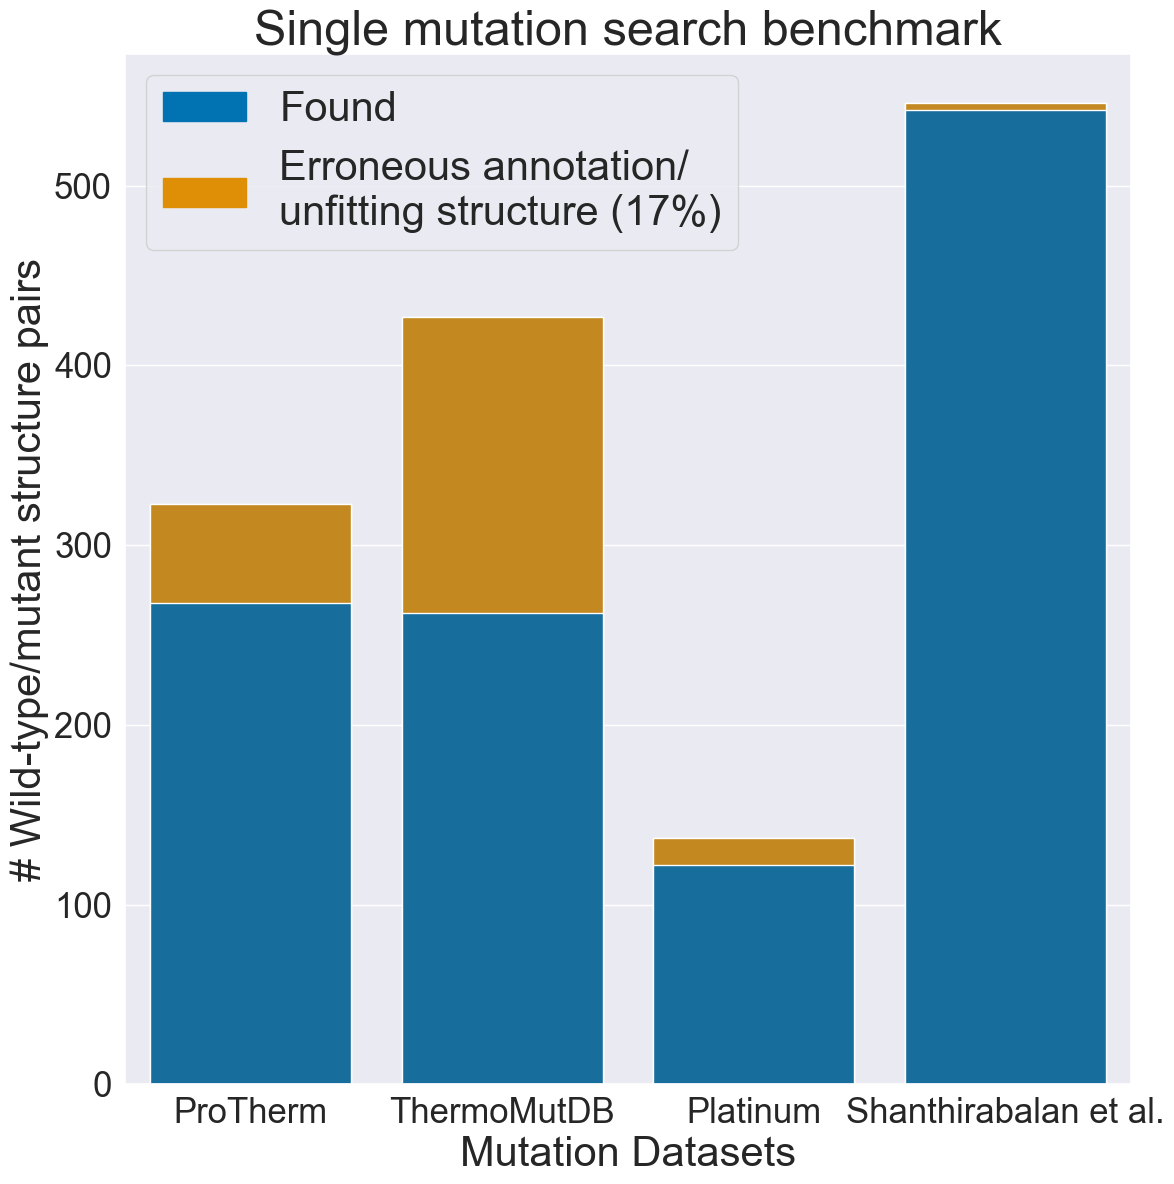

In [15]:
plt.rcParams['pdf.fonttype'] = 42  # Type 1 fonts
plt.rcParams['ps.fonttype'] = 42   # Type 1 fonts

sns.set()

fig, ax = plt.subplots(1, 1, figsize=(12, 12), sharey=False, sharex=False,  )#dpi=600)
plus = 10
subplot_title_size = 25 + plus
tick_size = 15+ plus
x_label_size = 20+ plus
y_label_size = 20+ plus
legend_font_size = 22 + plus - 2

dataset_order = ['protherm', 'thermomutdb', 'platinum', 'shanthirabalan']
sns.barplot(data=df_counts, x='dataset', y='all', color=pal[2], order=dataset_order,ax=ax)
# if np.any(df_corrected_counts['found'] != df_corrected_counts['all']):
sns.barplot(data=df_corrected_counts, x='dataset', y='really_not_found4plotting', color=pal[1], ax=ax, order=dataset_order)
sns.barplot(data=df_corrected_counts, x='dataset', y='found', color=pal[0], ax=ax, order=dataset_order, dodge=False)

ax.set_ylabel('# Wild-type/mutant structure pairs', fontsize=y_label_size)
ax.set_xlabel('Mutation Datasets', fontsize=x_label_size)
ax.set_xticks(range(len(dataset_order)), ['ProTherm', 'ThermoMutDB', 'Platinum', 'Shanthirabalan et al.'])
patches = [matplotlib.patches.Patch(color=pal[0], label='Found'),
           matplotlib.patches.Patch(color=pal[1], label='Erroneous annotation/\nunfitting structure ({number:.{digits}f}%)'.format(
               number=100 - successrate, digits=0)),
          ]
if np.any(df_corrected_counts['found'] != df_corrected_counts['all']):
    patches += [matplotlib.patches.Patch(color=pal[2], label='Not found ({number:.{digits}f}%)'.format(
                number=100 - successrate_corrected, digits=1)),]
plt.legend(handles=patches, fontsize=legend_font_size)

ax.set_title('Single mutation search benchmark', fontsize=subplot_title_size)

ax.tick_params(labelsize=tick_size)

plt.tight_layout()

# plt.savefig(plots_outdir / 'evaluation_single_mutations.png', dpi=600)
# plt.savefig(plots_outdir / 'evaluation_single_mutations.pdf', dpi=900)
# plt.savefig(plots_outdir / 'evaluation_single_mutations.svg', dpi=900)
# plt.savefig(plots_outdir / 'evaluation_single_mutations.eps', dpi=600)
plt.savefig(plots_outdir / 'evaluation_single_mutations.tiff', dpi=600, pil_kwargs={"compression": "tiff_lzw"})
plt.savefig(plots_outdir / 'evaluation_single_mutations.jpeg', dpi=600)